<a href="https://colab.research.google.com/github/hyang0129/hyang0129/blob/main/MELANOMA_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MELANOMA DETECTION 

This notebook was used to train models for the kaggle competition https://www.kaggle.com/c/siim-isic-melanoma-classification. In this competition I placed 149th out of 3000 contestants. One of my submissions scored in the top 50th, but unfortunated I did not choose that submission as one of my final submissions. In this competition, I learned a lot about image classification, but also on the importance of a strong cross validation process. 

In this variant, I implemented weight sharing to help improve scale invariance. Effectively, the same network is trained on the same image at two resolutions and outputs a concatenated embedding of the pooled final layer for the CNN at two resolutions. This embedding is then used for the prediction. Ideally, the same network will learn how features at different scales for the same image function and leverage that information via the final concatenated embedding layer in a more effective manner than blending two different networks trained at two different resolutions. 

Unfortunately, this notebook saves models to a Google drive, so you may encounter errors in the training step when trying to run this notebook. 

Please note that this notebook is intended for use with a TPU. 

#SETUP

This handy bit of code detectsa the name of the notebook. This is useful for copying a notebook to test various hyper parameters. Simply change the name of the copied notebook and voila, you have two notebooks running separately testing different parameters. 

This method was preferred over using a config file to store hyper parameters. Using a config file requires a respository for the various configs, then a place to upload results for each config. For future projects, a config file setup may be utilized. However, the notebook name method allows for rapid prototyping with an acceptable level of organization. 




In [ ]:
from requests import get
nbname = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
nbname = nbname.replace('.ipynb', '')
nbname

'MELANOMA_DETECTION'

In [ ]:
!pip install -q efficientnet
!pip install tensorflow_addons==0.10.0

In [ ]:
import math, re, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
import cv2
import tensorflow_addons as tfa
import PIL
import tensorflow.keras.backend as K

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


#HYPER PARAMETERS

This process initializes the TPU and GCS datasets. We also use bfloat16 training. 

In [ ]:
GCS_DS_PATH = 'gs://kaggledata2/melanoma/512'
GCS_DS_PATH_ADD = 'gs://kaggledata2/melanoma/2019_512'
GSC_DS_PATH_ADD2 = 'gs://kaggledata2/melanoma/512_malig'


backbone = efn.EfficientNetB5

BATCH_SIZE = 8 * 8

folds = 5
SEED = 13
fold = 1

DIM = 512
NETDIM = DIM
CROPDIM = DIM
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 20

CATEGORIES = 8
TTA = 10
VERBOSE = 1
STACK_DIVS = [1, 2]

model_save_path =  '/content/drive/Shared drives/KAGGLE/MELANOMA/'

tabular_data = True 

training = True

policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
tf.keras.mixed_precision.experimental.set_policy(policy)

In [ ]:
import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

import tensorflow as tf
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


TPU address is grpc://10.16.60.50:8470
Running on TPU  grpc://10.16.60.50:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
all_records = []
all_records = tf.io.gfile.glob(GCS_DS_PATH + '/train*.tfrec*')
    



In [ ]:

additional_train_records = []
if GCS_DS_PATH_ADD:

  additional_train_records += [rec for rec in tf.io.gfile.glob(GCS_DS_PATH_ADD + '/train*.tfrec*') if int(rec.split('/')[-1][5:7])%2 == 0]
#   additional_train_records += [rec for rec in tf.io.gfile.glob(GCS_DS_PATH_ADD + '/train*.tfrec*')]

if GSC_DS_PATH_ADD2:
    additional_train_records += tf.io.gfile.glob(GSC_DS_PATH_ADD2 + '/train*.tfrec*')[15:30]

additional_train_records

['gs://kaggledata2/melanoma/2019_512/train00-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train02-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train04-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train06-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train08-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train10-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train12-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train14-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train16-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train18-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train20-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train22-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train24-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train26-858.tfrec',
 'gs://kaggledata2/melanoma/2019_512/train28-847.tfrec',
 'gs://kaggledata2/melanoma/512_malig/train15-39.tfrec',
 'gs://kaggledata2/melanoma/512_malig/train16-39.tfrec',
 'gs://kaggledata2/melanoma/512

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

#DATA PREP

This section prepares the dataset for training. 

In addition to the standard augmentations, dropout was used. 

## CODE

In [ ]:
def read_labeled_tfrecord(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'patient_id': tf.io.FixedLenFeature([], tf.int64),
        'sex': tf.io.FixedLenFeature([], tf.int64),
        'age_approx': tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'target': tf.io.FixedLenFeature([], tf.int64),
    }          
    example = tf.io.parse_single_example(example, features)

    tabular  = (example['sex'], example['age_approx'], example['anatom_site_general_challenge'])

    return example['image'], example['target'], tabular
                              


def parse_image(img, label = None):

  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32) / 255.0

  img = tf.image.resize(img, (DIM, DIM))

  if training: 
    label =  tf.cast(label, tf.float32)
    
  return img, label


def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = 180.0  * tf.random.normal([1], dtype='float32')
    shr = 2.0 * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / 8.0
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / 8.0
    h_shift = 8.0 * tf.random.normal([1], dtype='float32') 
    w_shift = 8.0 * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])


def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input - one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed

    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1) < PROBABILITY, tf.int32)
    if (P == 0)|(CT == 0)|(SZ == 0): return image

    for k in range( CT ):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)

    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

def augment_img(img, label = None):

    img = transform(img)
    img = tf.image.random_crop(img, [CROPDIM, CROPDIM, 3])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_hue(img, 0.01)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_brightness(img, 0.1)
    img = dropout(img, DIM = NETDIM, PROBABILITY = 0.75, CT = 12, SZ = 0.2)

    return img, label

def mixup(image, label, PROBABILITY = 0.5):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = CROPDIM
    
    imgs = []; labs = []
    for j in range(BATCH_SIZE):
       
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,BATCH_SIZE),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)


        lab1 = label[j]
        lab2 = label[k]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(BATCH_SIZE,1))
    return image2,label2

def batch_augment_img(img, label):
  img, label = mixup(img, label)

  return img, label

def resize(img, label = None):
  imgs = []

  for i in STACK_DIVS:
    size = int(NETDIM//i)
    imgs.append(tf.image.resize(img, (size , size)))

  return tuple(imgs), label 

def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024)

    ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    ds = ds.map(tab_fix(parse_image), num_parallel_calls=AUTO)
    
    if augment:
      ds = ds.map(tab_fix(augment_img), num_parallel_calls=AUTO)
      ds = ds.batch(BATCH_SIZE)
    #   ds = ds.map(tab_fix(batch_augment_img), num_parallel_calls=AUTO)

    else: 
      ds = ds.batch(BATCH_SIZE)

    ds = ds.map(tab_fix(resize))

    if tabular_data:
        ds = ds.map(prep_tab)

    ds = ds.prefetch(AUTO)
    return ds

def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)

def read_unlabeled_tfrecord(example, return_image_name = True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'sex': tf.io.FixedLenFeature([], tf.int64),
        'age_approx': tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, tfrec_format)


    tabular  = (example['sex'], example['age_approx'], example['anatom_site_general_challenge'])
                          
    return example['image'], example['image_name'] if return_image_name else 0, tabular 

def tab_fix(func): 

    def fixed(image, label = None, tabular = None):

        image, label = func(image, label)

        return image, label, tabular

    return fixed

def prep_tab(image, label, tabular):

    sex = tf.reshape(tf.cast(tabular[0], tf.float32), (-1, 1))

    age = tf.one_hot(tabular[1]//5, depth = 16)

    loc = tf.one_hot(tabular[2], depth = 5)
    tab = tf.concat([sex, age, loc], axis = 1)

    if len(STACK_DIVS) == 1: 
        inputs = tuple(image, tab)
    else:
        inputs = [img for img in image]
        inputs.append(tab)
        inputs = tuple(inputs)

    return inputs, label

def get_test_dataset(files, augment = True, return_image_names = False, repeat = True):

    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    if repeat:
        ds = ds.repeat()
    ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                        num_parallel_calls=AUTO)  
    
    ds = ds.map(tab_fix(parse_image), num_parallel_calls=AUTO)


    if augment:
        ds = ds.map(tab_fix(augment_img), num_parallel_calls=AUTO)
        ds = ds.batch(BATCH_SIZE)
        # ds = ds.map(batch_augment_img, num_parallel_calls=AUTO)
    else:
        ds = ds.batch(BATCH_SIZE)
    ds = ds.map(tab_fix(resize))

    if tabular_data:
        ds = ds.map(prep_tab)

    ds = ds.prefetch(AUTO)

    return ds 

# ds = get_dataset(all_records, augment = True, shuffle = True, repeat = True)

ds = get_test_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/test*.tfrec*'))
for i in ds.take(1):
  for t in i[0]:
    print(t.shape)
  

(64, 512, 512, 3)
(64, 256, 256, 3)
(64, 22)


# DATA SAMPLES

This is with fairly aggresive dropout. 

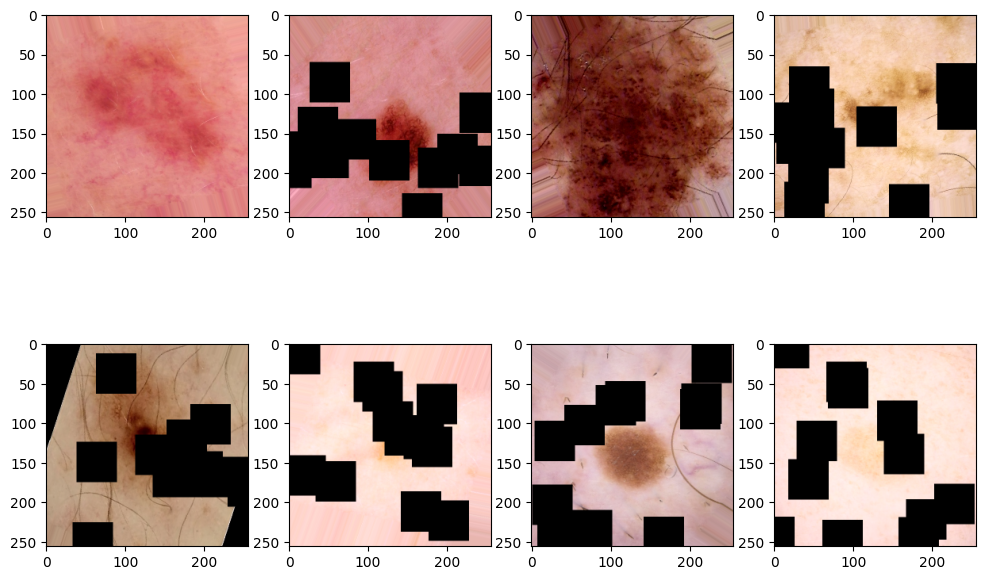

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

ds  = get_dataset(all_records, augment = True, shuffle = True, repeat = True)


def draw_grid(imgs, nrow, ncol):

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)

    for i, ax in enumerate(axs.reshape(-1)):

        img = imgs[i].numpy()
        
        ax.imshow(img)


draw_grid(list(ds.take(1))[0][0][1][:8], 2, 4)


#MODEL DEFINITION

A lot of the code below was designed for quick testing of different hyper parameters. After each run, the trained models would be saved in google drive based on the notebook name. Thus, it was easy to identify where to find the models that performed well. 



In [ ]:
def get_smooth_focal():
  
  def smoothfocal(y_true, y_pred): 
    smooth = 0.05
    y_true = y_true * (1 - smooth * 2) + smooth 

    return tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred)

  return smoothfocal 

class GeneralizedMeanPooling(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(GeneralizedMeanPooling, self).__init__()


    def build(self, input_shape):
        # pool power represents how we pool
        # pp = 1 results in average pool
        # pp = inf results in max pool 
        # defaults to average pool on build 

        self.pool_power = self.add_weight("pool_power",
                                          shape = [int(input_shape[-1])],
                                          
                                          )
        
        self.set_weights([tf.ones(shape = input_shape[-1], dtype = tf.float32) + 1])

    def call(self, input):
        # assume channel last
        input = tf.keras.activations.relu(input) + 1e-6
        
        return tf.pow(tf.keras.backend.mean(tf.pow(input, self.pool_power), axis = [1,2]), 1/self.pool_power)

    def compute_output_shape(self, input_shape):
        return tf.TensorShape([input_shape[0], input_shape[-1]])

    def get_config(self):
        config = {}
        base_config = super(GeneralizedMeanPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class Saver(tf.keras.callbacks.Callback): 
    
    def __init__(self, model_name): 
        super().__init__()
        self.model_name = model_name 
        # self.bucket = bucket 
        # self.fs = gcsfs.GCSFileSystem(project='tpu-44747', token = 'gckey.json')
        self.start = 5
        self.best = 0
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start: 
            pass
        
        try: 
            if logs.get('val_auc') >= 0.88 and logs.get('val_auc') > self.best: 
                print('saving good model')
                lpath = model_save_path + self.model_name + '.h5'
                self.model.save(lpath, include_optimizer=False)
                self.best = logs.get('val_auc')
        except Exception as E:
            print('encountered some error in model saving process')
            print(E)
            pass 


In [ ]:

def build_stacked_model(stack_divs):
    
    inputs = [] 
    pools = []
    output = []

    net = tf.keras.Sequential([
                backbone(
                    input_shape=(None, None, 3),
                    weights='imagenet',
                    include_top=False
                ),
                L.GlobalAveragePooling2D(),
            ])

    for i, div in enumerate(stack_divs):
        size = int(NETDIM//div)
        inputs.append(tf.keras.Input(shape = (size, size, 3)))
        pools.append(net(inputs[i]))
        

    if tabular_data:
        tab = tf.keras.Input(shape = (22,))
        inputs.append(tab)

        tab_model = tf.keras.Sequential([L.Dense(128),
                                         L.BatchNormalization(),
                                         L.Activation('relu'),
                                         L.Dropout(0.5),
                                         ])
        
        tab_model2 = tf.keras.Sequential([L.Dense(128),
                                         L.BatchNormalization(),
                                         L.Activation('relu'),
                                         L.Dropout(0.5),
                                         ])
        
        tabout = tab_model(tab)
        # tabout = 
        tabout = tf.concat([tabout, tab_model2(tabout)], axis = 1)

        tab_out = tabout

        pools.append(tab_out)

        # output.append(tf.keras.layers.Dense(1, activation='sigmoid', dtype = tf.float32)(tab_out))

    concat = tf.concat(pools, axis = 1)

    
    output.append(tf.keras.layers.Dense(1, activation='sigmoid', dtype = tf.float32)(concat))

    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model


def get_model():
  with strategy.scope():
    # loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05)
    loss_fn = get_smooth_focal()
    
    metrics = tf.keras.metrics.AUC(name = 'auc')

    # model = build_model() 
    model = build_stacked_model(stack_divs = STACK_DIVS)

    optimizer = tf.keras.optimizers.Adam()
    optimizer = tfa.optimizers.LAMB(
        learning_rate = 1e-3,
        beta_1 = 0.9,
        beta_2 =  0.999,
        epsilon = 1e-06,
        weight_decay_rate =  1e-5,
        exclude_from_weight_decay =  ['bias', '_bn']
        )
      
    model.compile(
        optimizer = optimizer,
        loss = loss_fn,
        metrics=metrics,
    )

  return model 

def get_lr_callback(batch_size=8*16):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

def plot_history_df(df, fold):
  df[['val_auc', 'auc', 'loss', 'val_loss']].plot.line(title = 'Fold %i best val_auc %s' % (fold, str(df.val_auc.max())[:6] ) )

def train_model(train_dataset, valid_dataset, model_name, steps): 

  saver = Saver(model_name)
  csvlog =  tf.keras.callbacks.CSVLogger(model_save_path + model_name + '.csv')
  model = get_model()

  lr_schedule = get_lr_callback()

  history = model.fit(train_dataset, 
            steps_per_epoch  = steps,
            epochs           = EPOCHS, 
            validation_data = valid_dataset,
            verbose = VERBOSE,
            callbacks = [lr_schedule, saver, csvlog],
            )


  return history


def predict_with_best(test_dataset, model_name, TTA = TTA):


  with strategy.scope():
    model = tf.keras.models.load_model(model_save_path + model_name + '.h5',
                                       custom_objects ={'GeneralizedMeanPooling' : GeneralizedMeanPooling})

  steps = 10982 * TTA / BATCH_SIZE

  preds = model.predict(test_dataset, steps =steps, verbose = VERBOSE)

  preds = preds[ : 10982 * TTA, ]
  if not type(preds) == np.ndarray:
    preds = preds.numpy()
  preds = np.mean(preds.reshape((10982,TTA),order='F'),axis=1)

  return preds


# m = get_model()

# m.summary()

# TRAINING/TESTING PROCESS 

A simple 5 fold trainig process was used. Performance was saved to csv file.

When making predictions, this loop loads the saved models from each fold automatically. 

In [ ]:
from tqdm.notebook import tqdm

test_records = tf.io.gfile.glob(GCS_DS_PATH + '/test*.tfrec*')
test_dataset = get_test_dataset(test_records)

preds = []
histories = []

kfold = KFold(folds, shuffle = True, random_state = SEED)
for f, (trn_ind, val_ind) in tqdm(enumerate(kfold.split(all_records)), total = folds): 

  model_name = nbname + '_f{:02}'.format(f) 

  try:
    hist = pd.read_csv(model_save_path + model_name + '.csv')
    assert len(hist) == EPOCHS
  except:
    hist = []

  if training: 
      
    if len(hist) == EPOCHS: 
      print('Skipping Fold %i' % f )
    else: 
      print('Training Fold %i' % f )
      tf.tpu.experimental.initialize_tpu_system(tpu)
      K.clear_session()
      train_records, valid_records = np.array(all_records)[trn_ind], np.array(all_records)[val_ind]

      if GCS_DS_PATH_ADD:
        train_records = np.append(train_records, additional_train_records)
        np.random.shuffle(train_records)

      train_dataset = get_dataset(train_records, augment = True, shuffle = True, repeat = True)

      valid_dataset = get_dataset(valid_records)

      steps = count_data_items(train_records) // BATCH_SIZE

      history = train_model(train_dataset, valid_dataset, model_name, steps)
      histories.append(history)

  else: 
    print('Predicting Fold %i' % f)
    preds.append(predict_with_best(test_dataset, model_name))




Training Fold 0


INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


115515392/115515256 [==============================] - 2s 0us/step
Epoch 1/20
  6/618 [..............................] - ETA: 5:15 - loss: 0.1069 - auc: 0.5340WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0112s vs `on_train_batch_end` time: 21.7918s). Check your callbacks.


618/618 [==============================] - 615s 598ms/step - loss: 0.1190 - auc: 0.5808 - val_loss: 0.0730 - val_auc: 0.5556
Epoch 2/20
618/618 [==============================] - 333s 539ms/step - loss: 0.0484 - auc: 0.6307 - val_loss: 0.0100 - val_auc: 0.7626
Epoch 3/20
618/618 [==============================] - 333s 539ms/step - loss: 0.0347 - auc: 0.7532 - val_loss: 0.0090 - val_auc: 0.8421
Epoch 4/20
618/618 [==============================] - 333s 539ms/step - loss: 0.0310 - auc: 0.8179 - val_loss: 0.0087 - val_auc: 0.8565
Epoch 5/20
618/618 [==============================] - 333s 539ms/step - loss: 0.0292 - auc: 0.8433 - val_loss: 0.0085 - val_auc: 0.8701
Epoch 6/20
618/618 [==============================] - 333s 539ms/step - loss: 0.0267 - auc: 0.8687 - val_loss: 0.0083 - val_auc: 0.8890
saving good model
Epoch 7/20
618/618 [==============================] - 334s 540ms/step - loss: 0.0258 - auc: 0.8834 - val_loss: 0.0078 - val_auc: 0.8991
saving good model
Epoch 8/20
618/618 [===

INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
  6/618 [..............................] - ETA: 5:16 - loss: 0.1242 - auc: 0.5479WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0108s vs `on_train_batch_end` time: 22.6845s). Check your callbacks.


618/618 [==============================] - 627s 597ms/step - loss: 0.1545 - auc: 0.5264 - val_loss: 0.1171 - val_auc: 0.4703
Epoch 2/20
618/618 [==============================] - 334s 541ms/step - loss: 0.0597 - auc: 0.6008 - val_loss: 0.0109 - val_auc: 0.7178
Epoch 3/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0287 - auc: 0.8033 - val_loss: 0.0097 - val_auc: 0.7898
Epoch 4/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0257 - auc: 0.8508 - val_loss: 0.0091 - val_auc: 0.8271
Epoch 5/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0249 - auc: 0.8680 - val_loss: 0.0089 - val_auc: 0.8560
Epoch 6/20
618/618 [==============================] - 335s 541ms/step - loss: 0.0231 - auc: 0.8875 - val_loss: 0.0089 - val_auc: 0.8744
Epoch 7/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0217 - auc: 0.9026 - val_loss: 0.0084 - val_auc: 0.8717
Epoch 8/20
618/618 [==============================] - 335s 

INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
  6/618 [..............................] - ETA: 5:17 - loss: 0.1050 - auc: 0.4844WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0104s vs `on_train_batch_end` time: 23.1242s). Check your callbacks.


618/618 [==============================] - 629s 597ms/step - loss: 0.1104 - auc: 0.5581 - val_loss: 0.0764 - val_auc: 0.5589
Epoch 2/20
618/618 [==============================] - 334s 541ms/step - loss: 0.0476 - auc: 0.6277 - val_loss: 0.0099 - val_auc: 0.7840
Epoch 3/20
618/618 [==============================] - 334s 540ms/step - loss: 0.0328 - auc: 0.7755 - val_loss: 0.0090 - val_auc: 0.8506
Epoch 4/20
618/618 [==============================] - 335s 541ms/step - loss: 0.0297 - auc: 0.8282 - val_loss: 0.0084 - val_auc: 0.8735
Epoch 5/20
618/618 [==============================] - 334s 541ms/step - loss: 0.0277 - auc: 0.8593 - val_loss: 0.0082 - val_auc: 0.8822
saving good model
Epoch 6/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0264 - auc: 0.8741 - val_loss: 0.0085 - val_auc: 0.8857
saving good model
Epoch 7/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0254 - auc: 0.8874 - val_loss: 0.0079 - val_auc: 0.8974
saving good model
Epoch

INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
  6/618 [..............................] - ETA: 5:18 - loss: 0.1240 - auc: 0.4907WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0102s vs `on_train_batch_end` time: 22.8817s). Check your callbacks.


618/618 [==============================] - 631s 600ms/step - loss: 0.1361 - auc: 0.4963 - val_loss: 0.0770 - val_auc: 0.5543
Epoch 2/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0569 - auc: 0.5688 - val_loss: 0.0102 - val_auc: 0.7497
Epoch 3/20
618/618 [==============================] - 335s 543ms/step - loss: 0.0301 - auc: 0.7775 - val_loss: 0.0092 - val_auc: 0.8340
Epoch 4/20
618/618 [==============================] - 335s 543ms/step - loss: 0.0267 - auc: 0.8393 - val_loss: 0.0088 - val_auc: 0.8553
Epoch 5/20
618/618 [==============================] - 335s 543ms/step - loss: 0.0249 - auc: 0.8629 - val_loss: 0.0089 - val_auc: 0.8716
Epoch 6/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0239 - auc: 0.8778 - val_loss: 0.0090 - val_auc: 0.8871
saving good model
Epoch 7/20
618/618 [==============================] - 336s 543ms/step - loss: 0.0221 - auc: 0.8954 - val_loss: 0.0090 - val_auc: 0.8922
saving good model
Epoch 8/20
618/618 [===

INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.60.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
  6/618 [..............................] - ETA: 5:20 - loss: 0.1099 - auc: 0.5360WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0128s vs `on_train_batch_end` time: 22.4932s). Check your callbacks.


618/618 [==============================] - 629s 602ms/step - loss: 0.1148 - auc: 0.5237 - val_loss: 0.0910 - val_auc: 0.5537
Epoch 2/20
618/618 [==============================] - 335s 543ms/step - loss: 0.0500 - auc: 0.6144 - val_loss: 0.0101 - val_auc: 0.7598
Epoch 3/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0327 - auc: 0.7651 - val_loss: 0.0088 - val_auc: 0.8521
Epoch 4/20
618/618 [==============================] - 335s 543ms/step - loss: 0.0302 - auc: 0.8168 - val_loss: 0.0082 - val_auc: 0.8783
Epoch 5/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0287 - auc: 0.8384 - val_loss: 0.0079 - val_auc: 0.8963
saving good model
Epoch 6/20
618/618 [==============================] - 336s 544ms/step - loss: 0.0268 - auc: 0.8645 - val_loss: 0.0092 - val_auc: 0.8976
saving good model
Epoch 7/20
618/618 [==============================] - 335s 542ms/step - loss: 0.0256 - auc: 0.8763 - val_loss: 0.0081 - val_auc: 0.9041
saving good model
Epoch

# PREDICTION

To predict on the competition test set, rerun the notebook with the training hyperparameter set to false. 

In [ ]:
if not training:
  ds = get_test_dataset(test_records, return_image_names = True, repeat = False)

  image_names = np.array([img_name.numpy().decode("utf-8") 
                          for img, img_name in iter(ds.unbatch())])

  submission = pd.DataFrame(dict(image_name=image_names, target=np.mean(preds, axis = 0)))
  submission = submission.sort_values('image_name') 
  submission.to_csv(model_save_path + 'SUB/' + model_name + 'tta%i_pred.csv' % TTA, index=False)
  submission.head()
